In [1]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import zipfile
import glob
import re
from pathlib import Path
import pandas as pd
from distutils.dir_util import copy_tree
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import subprocess
import sys
import skimage.io as io
tf.__version__, np.__version__

('2.8.0', '1.21.6')

In [2]:
INPUT_IMAGE_SHAPE= 224
force_create = True

In [3]:

if(force_create == True):
  if(os.path.isdir('/tmp/dataset') == True):
    subprocess.run(["rm", "-rf", "/tmp/dataset"])
  # if(os.path.isdir('/tmp/lfw') == True):
  #   subprocess.run(["rm", "-rf", "/tmp/lfw"])
  # if(os.path.isdir('/tmp/mlfw') == True):
  #   subprocess.run(["rm", "-rf", "/tmp/mlfw"])


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
def extract_lfw_mlfw():
  if(os.path.isdir('/tmp/lfw') == False):
    cmd = "tar -xvf gdrive/MyDrive/datasets/lfw.tar -C /tmp/"
    returned_value = os.system(cmd)
  if(os.path.isdir('/tmp/lfw-deepfunneled') == True):
    os.rename('/tmp/lfw-deepfunneled','/tmp/lfw')

  if(os.path.isdir('/tmp/mlfw/')== False):
    zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/datasets/MLFW.zip", 'r')
    zip_ref.extractall("/tmp/mlfw/")
    zip_ref.close()

In [6]:
def pick_images_lfw():
  lfw_images = []
  lfw_train = sorted(os.listdir("/tmp/lfw/"))
  for directory in lfw_train:
    dir_path = "/tmp/lfw/" + directory
    no_of_files = len(os.listdir(dir_path)) 
    if(no_of_files >= 3 and no_of_files <= 5):
      lfw_images.append(directory)
  return lfw_images;

In [7]:
def create_common_dir_list():
  extract_lfw_mlfw();
  lfw_dir = pick_images_lfw();
  mlfw_dir = pick_images_mlfw()
  common_set = set(lfw_dir) & set(mlfw_dir)
  return list(common_set)

In [8]:
def pick_images_mlfw():
  file_list = glob.glob("/tmp/mlfw/origin/*.jpg")
  final_name_list = []
  for file in file_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str)  
  print(len(set(final_name_list)))
  df = pd.DataFrame(final_name_list)
  df.columns = ['name']
  new_df = df.groupby('name').filter(lambda x : (len(x) >= 3 and len(x) <= 5))
  mlfw_images = new_df.values.tolist()
  mlfw_images = [sub[0][ : -1] for sub in mlfw_images]
  return list(set(mlfw_images))


In [9]:
def pick_classes(no_of_classes):
  final_list = []
  filtered_list =  create_common_dir_list()
  print("filtered_list_length = " + str(len(filtered_list)))
  for i in range(0, no_of_classes):
      final_list.append(random.choice(filtered_list))
  return final_list

In [10]:
def create_train_test_set_from_lfw_mlfw():
  final_class_list = pick_classes(100)
  print(final_class_list)
  if(os.path.isdir('/tmp/dataset/train') == True):
    shutil.rmtree('/tmp/dataset/train')
  if(os.path.isdir('/tmp/dataset/test') == True):
    shutil.rmtree('/tmp/dataset/test')
  if(os.path.isdir('/tmp/dataset/')  == False):
    os.mkdir('/tmp/dataset/')
  if(os.path.isdir('/tmp/dataset/train')== False):
    os.mkdir('/tmp/dataset/train')
  if(os.path.isdir('/tmp/dataset/test')== False):
    os.mkdir('/tmp/dataset/test')

  for dir in final_class_list:  
    os.system("cp -r " + " /tmp/lfw/"+ dir + " /tmp/dataset/train")
  
  mlfw_jpg_list = []
  for path, subdirs, files in os.walk('/tmp/mlfw/aligned/'):
      for name in files:
          mlfw_jpg_list.append(os.path.join(path, name))

  for dir in final_class_list:
    if(os.path.isdir('/tmp/dataset/test/'+dir)  == False):
      os.mkdir('/tmp/dataset/test/'+dir)
    name_list = [k for k in mlfw_jpg_list if dir in k]
    for nme in name_list:
      shutil.copy(nme, "/tmp/dataset/test/"+dir + "/")

In [11]:
!pip install mtcnn

In [12]:
from mtcnn.mtcnn import MTCNN
from numpy import asarray
import cv2
from PIL import Image
!pip install imagesize
import imagesize
# extract a single face from a given photograph
def process_face(filename, required_size=(INPUT_IMAGE_SHAPE, INPUT_IMAGE_SHAPE)):
  # load image from file
  image = Image.open(filename)
  # # convert to RGB, if needed
  # image = image.convert('RGB')
  # convert to array
  pixels = asarray(image)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
  if(results):
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    cv2.imwrite(filename, face_array)
    new_size = imagesize.get(filename)
    print("image size", new_size)
    if(new_size[0] != INPUT_IMAGE_SHAPE):
      print("deleted image size", filename,new_size)
      os.remove(filename)

In [13]:
def get_image_list_from_folder(path):
  final_list = []
  for path, subdirs, files in os.walk(path):
    for name in files:
        final_list.append(os.path.join(path, name))
  return sorted(final_list)

def process_faces(image_list):
  for file in image_list:
    process_face(file)

In [14]:
def plot_images(w, h, fig_w, fig_h, image_list, columns, rows):
  fig = plt.figure(figsize=(fig_w, fig_h))
  for i in range(1, columns*rows +1):
      img = mpimg.imread(image_list[i])
      fig.add_subplot(rows, columns, i)
      plt.title(os.path.basename(image_list[i]))
      plt.imshow(img)
  plt.show()

In [15]:
if(force_create == True):
  create_train_test_set_from_lfw_mlfw()

2996
filtered_list_length = 156
['James_Traficant', 'Muhammad_Saeed_al-Sahhaf', 'Robert_Bonner', 'Natalie_Maines', 'Bruce_Springsteen', 'Hilary_Duff', 'Lynn_Redgrave', 'Thabo_Mbeki', 'Fred_Thompson', 'Angelo_Reyes', 'Orlando_Bloom', 'James_Cunningham', 'Candice_Bergen', 'Carlo_Ancelotti', 'Zoran_Djindjic', 'Salman_Rushdie', 'Jorge_Batlle', 'Jose_Canseco', 'Rita_Wilson', 'Naoto_Kan', 'Thabo_Mbeki', 'Robert_Bonner', 'Joseph_Biden', 'Hilary_Duff', 'Prince_Claus', 'Elena_Bovina', 'Fred_Thompson', 'Robert_Bonner', 'Hilary_Duff', 'Mike_Tyson', 'Rachel_Griffiths', 'Muhammad_Saeed_al-Sahhaf', 'John_Swofford', 'Roseanne_Barr', 'Jose_Canseco', 'Abdoulaye_Wade', 'Ashanti', 'Abdoulaye_Wade', 'Conan_OBrien', 'James_Cameron', 'Claudia_Pechstein', 'Elena_Bovina', 'Lynn_Redgrave', 'Vanessa_Incontrada', 'Makhdoom_Amin_Fahim', 'Hilary_Duff', 'Robert_Bonner', 'Lynn_Redgrave', 'Mathias_Reichhold', 'Hilary_Duff', 'Ronald_Reagan', 'Ronaldo_Luis_Nazario_de_Lima', 'George_Ryan', 'Abid_Hamid_Mahmud_Al-Tikriti'

In [16]:
train_list = get_image_list_from_folder('/tmp/dataset/train/')
plot_images(10, 10, 50, 50, train_list, 5, 5)
print(train_list)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
if(force_create == True):
  train_list = get_image_list_from_folder('/tmp/dataset/train/')
  process_faces(train_list)
  # train_len = int(len(train_list))
  # per_row = int(math.sqrt(train_len))
  # subprocess.run(["cd", "/content/gdrive/MyDrive/mfr_test_repo/MaskTheFace/"])
  os.chdir('/content/gdrive/MyDrive/mfr_test_repo/MaskTheFace/')
  # !pip install -r requirements.txt
  # subprocess.run(["!pip", "install", "dotmap"])
  for path in Path('/tmp/dataset/train/').rglob('*.jpg'):
    print ("generating for path" , path)
    result = subprocess.run(["python", "/content/gdrive/MyDrive/mfr_test_repo/MaskTheFace/mask_the_face.py",'--path', path, '--mask_type', 'all', '--verbose', '--write_original_image'],  stdout=subprocess.PIPE, text=True)   
    print(result.stdout)
train_list = get_image_list_from_folder('/tmp/dataset/train/')
plot_images(10, 10, 50, 50, train_list, 5, 5)
print(train_list)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
test_list = get_image_list_from_folder('/tmp/dataset/test/')
if(force_create == True):
  process_faces(test_list)
plot_images(10, 10, 50, 50, test_list, 5, 5)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
def get_data_list(path):
  img_list = get_image_list_from_folder(path)
  all_images = []
  for file in img_list:
      img = cv2.imread(file)
      img = cv2.resize(img,(160,160))
      all_images.append(img)
  final_name_list = []
  for file in img_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          token = token.split(".",1)[0]
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str) 
  final_name_list = [sub[ : -1] for sub in final_name_list]
  return all_images, final_name_list

In [20]:
def create_dataset():
  newTrainX, trainy = get_data_list('/tmp/dataset/train/')
  newTrainX = asarray(newTrainX)
  newTestX, testy = get_data_list('/tmp/dataset/test/')
  newTestX = asarray(newTestX)
  return newTrainX, asarray(trainy), newTestX, asarray(testy)

In [21]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

In [22]:
def get_train_test_list():
  train_folders = os.listdir("/tmp/dataset/train")
  num_train = int(len(train_folders))
  test_folders = os.listdir("/tmp/dataset/test")
  num_test = int(len(test_folders))
  train_list, test_list = {}, {}

  for folder in train_folders:
      num_files = len(os.listdir(os.path.join("/tmp/dataset/train", folder)))
      train_list[folder] = num_files
  for folder in test_folders:
    num_files = len(os.listdir(os.path.join("/tmp/dataset/test", folder)))
    test_list[folder] = num_files
  return train_list, test_list

train_list, test_list = get_train_test_list()
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 72
Length of testing list : 72

Test List: {'Roseanne_Barr': 4, 'Gary_Doer': 5, 'George_Ryan': 4, 'Arlen_Specter': 5, 'Chen_Shui-bian': 3, 'Mohammed_Baqir_al-Hakim': 4, 'Federico_Trillo': 4, 'Rachel_Griffiths': 5, 'Naoto_Kan': 4, 'Joseph_Biden': 4, 'Natalie_Maines': 4, 'Ronaldo_Luis_Nazario_de_Lima': 4, 'Abdoulaye_Wade': 5, 'Salman_Rushdie': 4, 'Hitomi_Soga': 3, 'LeBron_James': 4, 'Paul_Wellstone': 5, 'Sandra_Bullock': 5, 'Hipolito_Mejia': 4, 'Jose_Canseco': 3, 'Mike_Tyson': 4, 'Xanana_Gusmao': 4, 'Prince_Claus': 3, 'Justin_Guarini': 4, 'Sally_Field': 3, 'Ashanti': 5, 'Mathias_Reichhold': 3, 'Elena_Bovina': 5, 'Nadia_Petrova': 3, 'Claudia_Pechstein': 4, 'William_Bratton': 5, 'Fred_Thompson': 4, 'Orlando_Bloom': 5, 'George_Pataki': 3, 'Gary_Carter': 5, 'James_Cameron': 5, 'Rita_Wilson': 4, 'Mary-Kate_Olsen': 4, 'Marcelo_Salas': 4, 'Lynn_Redgrave': 5, 'Derek_Jeter': 5, 'Candice_Bergen': 3, 'Makhdoom_Amin_Fahim': 3, 'Abid_Hamid_Mahmud_Al-Tikriti': 5, 'Caroline_Ken

In [23]:
def rename_file_names(path):
  train_folders = os.listdir(path)
  for folder in train_folders:
    i = 0
    folder_path = os.path.join(path, folder)
    for file in os.listdir(folder_path):
      os.rename(folder_path + '/' +file, (folder_path + '/' +str(i) +'.jpg'))
      i = i + 1

In [24]:
if(force_create == True):
  rename_file_names("/tmp/dataset/train")
  rename_file_names("/tmp/dataset/test")

In [25]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

# New Section

In [26]:
train_triplet = create_triplets('/tmp/dataset/train', train_list)
test_triplet  = create_triplets('/tmp/dataset/test', test_list)
print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 3201
Number of testing triplets : 483

Examples of triplets:
(('Rita_Wilson', '3.jpg'), ('Rita_Wilson', '7.jpg'), ('Vanessa_Incontrada', '8.jpg'))
(('Candice_Bergen', '2.jpg'), ('Candice_Bergen', '3.jpg'), ('Ed_Smart', '7.jpg'))
(('James_Cameron', '1.jpg'), ('James_Cameron', '5.jpg'), ('Claudia_Pechstein', '12.jpg'))
(('Prince_Willem-Alexander', '5.jpg'), ('Prince_Willem-Alexander', '8.jpg'), ('Mohammed_Baqir_al-Hakim', '18.jpg'))
(('Arlen_Specter', '3.jpg'), ('Arlen_Specter', '7.jpg'), ('Tom_Watson', '6.jpg'))


**Creating Batch-Generator**

Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

Batch_size: Batch_size of the data to return
Preprocess: Whether to preprocess the data or not

In [27]:
def get_batch(triplet_list, path, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor  = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a, path))
            positive.append(read_image(p, path))
            negative.append(read_image(n, path))
            j+=1

      
        anchor =  np.array(anchor)
        positive =  np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

       
        result = [anchor, positive, negative]
        yield (result)

**Plotting the Data**

Plotting the data generated from get_batch() to see the results

In [28]:
from keras.preprocessing.image import img_to_array
def read_image(index, img_path):
    path = os.path.join(img_path, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(image.shape[0] != INPUT_IMAGE_SHAPE):
      image = cv2.resize(image.astype(np.uint8), (INPUT_IMAGE_SHAPE, INPUT_IMAGE_SHAPE))
    return np.array(image)

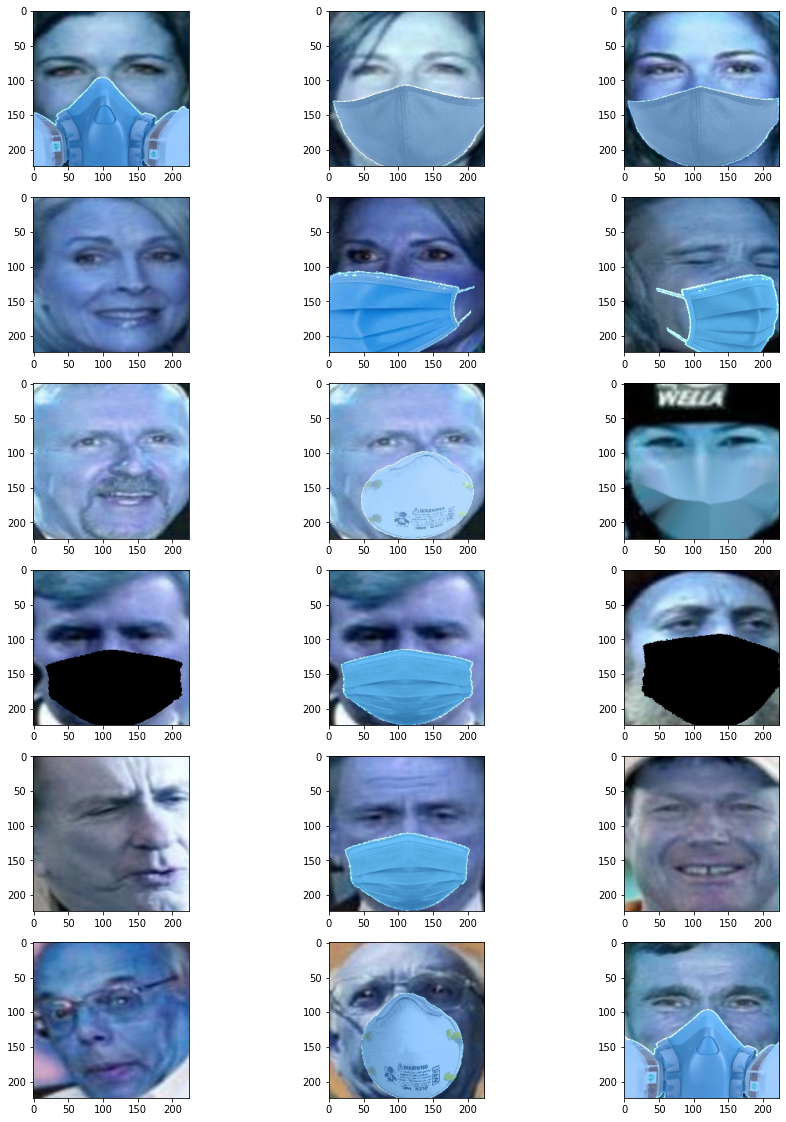

In [29]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet,'/tmp/dataset/train', batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

**Creating the Model**

Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

In [30]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

**Encoder**

The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [31]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    # pretrained_model = Xception(
    #     input_shape=input_shape,
    #     weights='imagenet',
    #     include_top=False,
    #     pooling='avg',
    # )

    # pretrained_model =tf.keras.applications.resnet50.ResNet50(
    #   include_top=True,
    #   weights='imagenet',
    #   input_tensor=None,
    #   input_shape=None,
    #   pooling=None,
    #   classes=1000
    # )

    # pretrained_model = tf.keras.applications.MobileNetV3Small(
    #       input_shape=None,
    #       alpha=1.0,
    #       minimalistic=False,
    #       include_top=True,
    #       weights="imagenet",
    #       input_tensor=None,
    #       classes=1000,
    #       pooling=None,
    #       dropout_rate=0.2,
    #       classifier_activation="softmax",
    #       include_preprocessing=True,
    #   )

    
    # for i in range(len(pretrained_model.layers)):
    #     pretrained_model.layers[i].trainable = False

    # encode_model = Sequential([
    #     pretrained_model,
    #     layers.Flatten(),
    #     layers.Dense(512, activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.Dense(256, activation="relu"),
    #     layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    # ], name="Encode_Model")

    base_cnn = tf.keras.applications.resnet50.ResNet50(
      weights="imagenet", input_shape= (224,224,3), include_top=False)

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    encode_model = Model(base_cnn.input, output, name="Encode_Model")

    trainable = False
    for layer in base_cnn.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable

    return encode_model

In [32]:
# pretrained_model_1 = Xception(
#       input_shape=(128,128, 3),
#       weights='imagenet',
#       include_top=False,
#       pooling='avg',
#   )
# # pretrained_model_1.summary()
# len(pretrained_model_1.layers)

In [33]:
# test_pretrained_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000
# )

# print(len(test_pretrained_model.layers))
# # test_pretrained_model.summary()

**Siamese Network**

We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

In [34]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (INPUT_IMAGE_SHAPE, INPUT_IMAGE_SHAPE, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                  

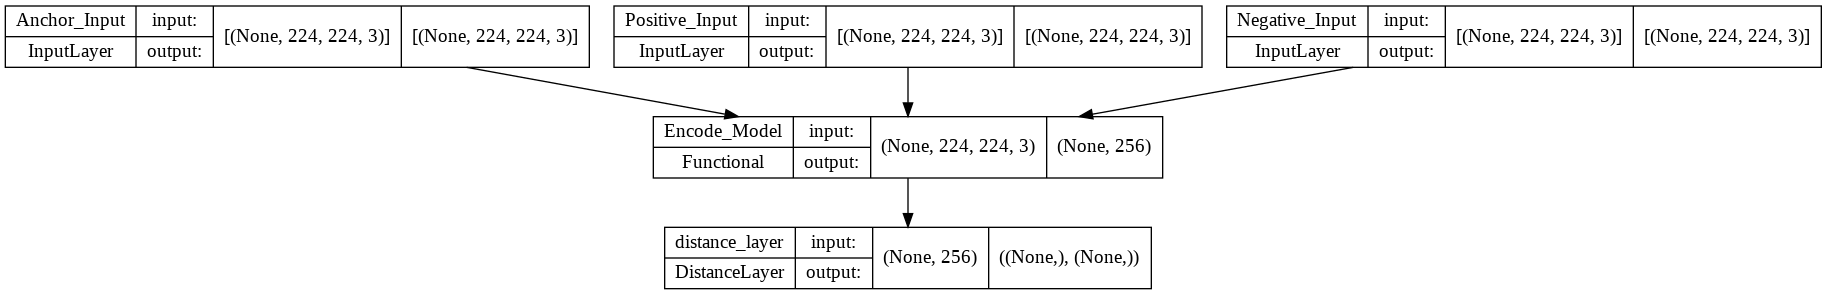

In [35]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

**Putting everything together**

We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

In [36]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [37]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

**Training the Model**

We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

**Test Function**

test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [38]:
def test_on_triplets(path, batch_size = 256):
    pos_scores, neg_scores = [], []

    # print(test_triplet)
    for data in get_batch(test_triplet, path, batch_size=batch_size, preprocess=False):
        
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [39]:
save_all = False
epochs = 256
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    #Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, '/tmp/dataset/train', batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets('/tmp/dataset/test', batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 63 sec)
Loss on train    = 0.98199
Accuracy on test = 0.62112

EPOCH: 2 	 (Epoch done in 49 sec)
Loss on train    = 0.54852
Accuracy on test = 0.64389

EPOCH: 3 	 (Epoch done in 51 sec)
Loss on train    = 0.56185
Accuracy on test = 0.63768

EPOCH: 4 	 (Epoch done in 50 sec)
Loss on train    = 0.27075
Accuracy on test = 0.61905

EPOCH: 5 	 (Epoch done in 51 sec)
Loss on train    = 0.26078
Accuracy on test = 0.63354

EPOCH: 6 	 (Epoch done in 51 sec)
Loss on train    = 0.20367
Accuracy on test = 0.62319

EPOCH: 7 	 (Epoch done in 51 sec)
Loss on train    = 0.11910
Accuracy on test = 0.63561

EPOCH: 8 	 (Epoch done in 50 sec)
Loss on train    = 0.10769
Accuracy on test = 0.62319

EPOCH: 9 	 (Epoch done in 51 sec)
Loss on train    = 0.07521
Accuracy on test = 0.64596

EPOCH: 10 	 (Epoch done in 51 sec)
Loss on train    = 0.07349
Accuracy on test = 0.65424

EPOCH: 11 	 (Epoch done in 51 sec)
Loss on train    = 0.11807
Accuracy on test = 0.62733

EPOCH: 12 	 (Epoch

**Evaluating the Model**

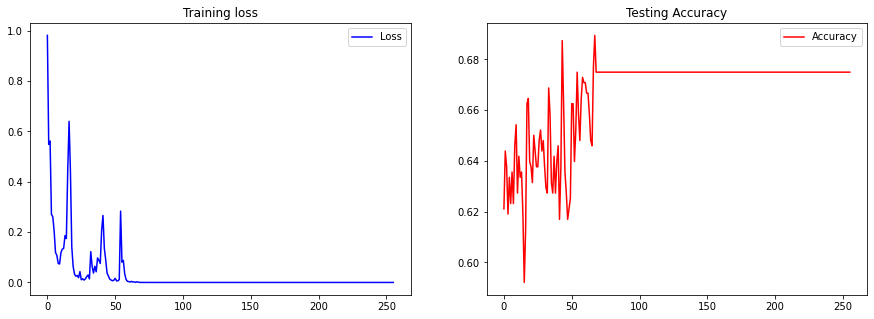

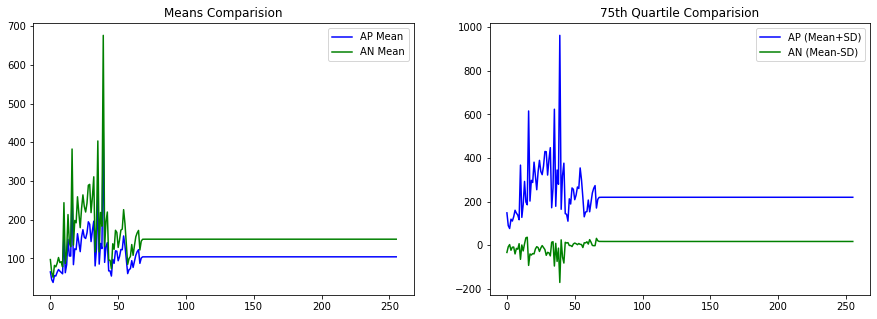

In [40]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

**Using the Model**

Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for latter use.

In [41]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1676 (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1676[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                       

**Classify Images¶**

To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [42]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.548828125



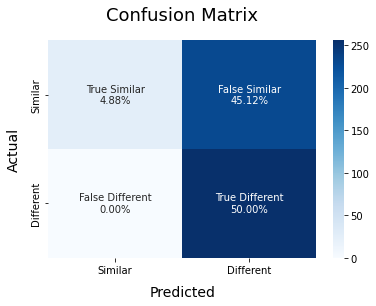

In [43]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet,'/tmp/dataset/test', batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)